In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import glob
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Initializing constant parameters 
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
batch_size = 32
train_input_shape = (256, 256, 3)
n_classes = 3

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=15,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=0.1,
                                   zoom_range=0.5,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory="/content/drive/MyDrive/dl_potato/train",
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True
                                                   )

valid_generator = train_datagen.flow_from_directory(directory="/content/drive/MyDrive/dl_potato/test",
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 974 images belonging to 3 classes.
Found 272 images belonging to 3 classes.
Total number of batches = 30 and 8


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True
    
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(128, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
optimizer = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=4
                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
30/30 [==============================] - 89s 2s/step - loss: 1.0535 - accuracy: 0.4703 - val_loss: 1.2998 - val_accuracy: 0.0820 - lr: 1.0000e-05
Epoch 2/50
30/30 [==============================] - 35s 1s/step - loss: 0.9244 - accuracy: 0.5403 - val_loss: 1.3261 - val_accuracy: 0.4727 - lr: 1.0000e-05
Epoch 3/50
30/30 [==============================] - 34s 1s/step - loss: 0.8681 - accuracy: 0.6157 - val_loss: 1.3193 - val_accuracy: 0.1992 - lr: 1.0000e-05
Epoch 4/50
30/30 [==============================] - 40s 1s/step - loss: 0.8259 - accuracy: 0.6645 - val_loss: 1.3819 - val_accuracy: 0.4766 - lr: 1.0000e-05
Epoch 5/50
30/30 [==============================] - 34s 1s/step - loss: 0.7875 - accuracy: 0.6826 - val_loss: 1.1937 - val_accuracy: 0.4844 - lr: 1.0000e-05
Epoch 6/50
30/30 [==============================] - 34s 1s/step - loss: 0.7757 - accuracy: 0.6879 - val_loss: 1.2690 - val_accuracy: 0.4727 - lr: 1.0000e-05
Epoch 7/50
30/30 [==============================] - 34s 1s

In [ ]:
# Freeze core ResNet layers and train again 
for layer in model.layers[-6:]:
   layer.trainable = False

for layer in model.layers:
    layer.trainable = True

optimizer = Adam(lr=0.00001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=4                             
                              )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
30/30 [==============================] - 44s 1s/step - loss: 0.6896 - accuracy: 0.7856 - val_loss: 0.7074 - val_accuracy: 0.8594 - lr: 1.0000e-05
Epoch 2/50
30/30 [==============================] - 34s 1s/step - loss: 0.6689 - accuracy: 0.8355 - val_loss: 0.6500 - val_accuracy: 0.9141 - lr: 1.0000e-05
Epoch 3/50
30/30 [==============================] - 34s 1s/step - loss: 0.6572 - accuracy: 0.8270 - val_loss: 0.6364 - val_accuracy: 0.9453 - lr: 1.0000e-05
Epoch 4/50
30/30 [==============================] - 35s 1s/step - loss: 0.6631 - accuracy: 0.8291 - val_loss: 0.6064 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 5/50
30/30 [==============================] - 35s 1s/step - loss: 0.6511 - accuracy: 0.8248 - val_loss: 0.5854 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 6/50
30/30 [==============================] - 34s 1s/step - loss: 0.6407 - accuracy: 0.8429 - val_loss: 0.5485 - val_accuracy: 0.9570 - lr: 1.0000e-05
Epoch 7/50
30/30 [==============================] - 35s 1s

In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

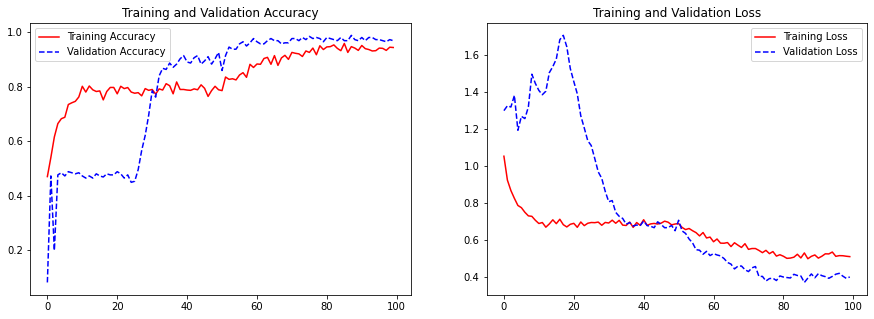

In [ ]:
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [ ]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator)
print("Prediction accuracy on train data =", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Prediction accuracy on train data = 0.9989733099937439


In [ ]:
# Prediction accuracy on test data
score = model.evaluate_generator(valid_generator)
print("Prediction accuracy on test data =", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Prediction accuracy on test data = 0.9742646813392639


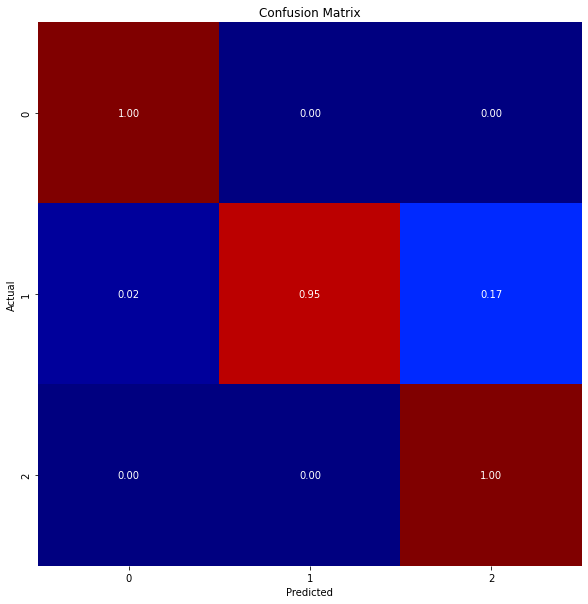

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       122
           1       1.00      0.95      0.97       116
           2       0.86      1.00      0.92        18

    accuracy                           0.98       256
   macro avg       0.94      0.98      0.96       256
weighted avg       0.98      0.98      0.98       256



In [ ]:
from sklearn.metrics import *
import seaborn as sns



def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes)))


showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

In [ ]:
model.save("ResnetNet_dl_potato.h5")

In [ ]:
from google.colab import files
files.download('/content/ResnetNet_dl_potato.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>